In [1]:
cd ..

/media/data/hastings/comp_755_project


In [2]:
from rl755.data.car_racing import encoded_rollouts
from rl755.data.common import processing
from rl755.models.car_racing import transformer
from rl755.models.car_racing import saved_models
from rl755.models.car_racing import unet

import importlib
import functools
import tensorflow as tf
import matplotlib.pyplot as plt
import config


In [3]:
vae = saved_models.raw_rollout_vae_32ld()

In [4]:
FLAGS = lambda: None
FLAGS.sequence_length = 128
FLAGS.batch_size=128

In [5]:
import numpy as np
from noise import pnoise1
import os
import random
def makeNoise(l):
    np.random.seed(hash(os.urandom(12)) % 5555555)
    start = np.random.random() * 10000
    out = []
    for _ in range(l):
        a = pnoise1(_ / 140 + start, 5)
        out.append(a)
    return np.array(out)

def mask():
    m = makeNoise(FLAGS.sequence_length) > 0
    m = m.reshape (FLAGS.sequence_length, 1)
    m = np.repeat(m, 37, 1)
    m[:, -4:] = 1
    return m

def cachemask(masks_=[mask() for _ in range(1000)]):
    return random.choice(masks_)



In [16]:


def to_ar_inputs_and_targets(x, sequence_length, latent_size=32, action_size=4):
    """Given a slice of a rollout, convert it to inputs and targets for autoregressive modelling.

    We do it like this:
        o[i], a[i], r[i-1] => o[i+1], r[i]
    The goal is to predict the next observation and reward given the action taken and the previous states
    and rewards.
    """
    r = tf.expand_dims(x["rewards"], axis=-1)
    a = x["actions"]
    o = x["observations"]
    inputs = tf.concat(
        [o[:], r[:], a[:]],
        axis=-1,
    )
    targets = tf.concat([o[:], r[:]], axis=-1)
    inputs = tf.reshape(inputs, [sequence_length, latent_size + action_size + 1])
    targets = tf.reshape(targets, [sequence_length, latent_size + 1])
    
    mask = tf.py_function(cachemask, inp=[], Tout=tf.float32)
    mask.set_shape(inputs.get_shape())
    return (inputs, mask), targets


def get_train_ds():
    ds = encoded_rollouts.random_rollout_slices(slice_size=FLAGS.sequence_length)
    ds = ds.map(
        functools.partial(
            to_ar_inputs_and_targets, sequence_length=FLAGS.sequence_length
        ),
        num_parallel_calls=1,
    )
    ds = processing.standard_dataset_prep(
        ds, batch_size=FLAGS.batch_size, repeat=True, shuffle_buffer_size=1000
    )
    return ds

def get_test_ds():
    ds = encoded_rollouts.random_rollout_slices(slice_size=FLAGS.sequence_length, split="validation")
    ds = ds.map(
        functools.partial(
            to_ar_inputs_and_targets, sequence_length=FLAGS.sequence_length
        ),
        num_parallel_calls=1,
    )
    ds = processing.standard_dataset_prep(
        ds, batch_size=FLAGS.batch_size, repeat=True, shuffle_buffer_size=1000
    )
    return ds

In [7]:
bd = get_train_ds()

In [8]:
aa = bd.as_numpy_iterator()
aa.next()
aa = aa.next()

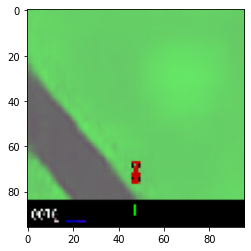

In [9]:
import numpy as np
video = np.array(vae.decode(aa[0][0][1, :, 0:32]))
plt.imshow(video[40])

In [11]:
import cv2
from matplotlib import animation
from IPython.display import HTML

#for frame in video:
#    cv2.imshow("title", frame)
#    cv2.waitKey(1)
    
def jupyter_video(video):
    fig = plt.figure()
    im = plt.imshow(video[0,:,:,:])

    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[0,:,:,:])

    def animate(i):
        im.set_data(video[i,:,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                                   interval=50)
    return HTML(anim.to_html5_video())

def decode_play(sequence):
    video = vae.decode(sequence[:, 0:32])
    return jupyter_video(video)

In [12]:
network = unet.sequence_unet()

(None, 128, 37)
(None, 64, 64)
(None, 32, 128)
(None, 16, 256)
(None, 8, 256)
(None, 4, 256)
(None, 2, 256)


In [64]:
network.compile(loss=tf.keras.losses.mse, optimizer="adam", metrics=[tf.keras.losses.mse])
network.fit(bd, steps_per_epoch=1000, epochs=70)

Train for 1000 steps
Epoch 1/70
1000/1000 [==============================] - 59s 59ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 2/70
1000/1000 [==============================] - 55s 55ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 3/70
1000/1000 [==============================] - 56s 56ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 4/70
1000/1000 [==============================] - 54s 54ms/step - loss: 0.0344 - mean_squared_error: 0.03440s - loss: 0.0344 - mean_squ
Epoch 5/70
1000/1000 [==============================] - 52s 52ms/step - loss: 0.0340 - mean_squared_error: 0.03404s - los - ETA: 2s - loss: 0.0340 -  - E
Epoch 6/70
1000/1000 [==============================] - 56s 56ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 7/70
1000/1000 [==============================] - 55s 55ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 8/70
1000/1000 [==============================] - 56s 56ms/step - loss: 0.0339 - mean_squared_error: 0.0339

In [65]:
network.save_weights("/media/hastings/4083E9FE44A0B1BD/comp_755_data/unet.hdf5")

In [14]:
network.load_weights(config.unet_weights_path)

In [66]:
bt = get_test_ds()
tb = bt.as_numpy_iterator().next()

0

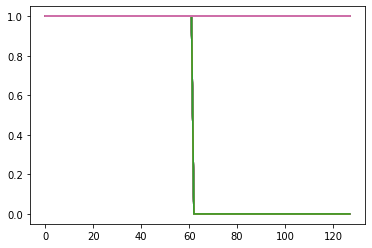

In [90]:
batch_index += 1 
plt.plot(tb[0][1][batch_index])
0

In [109]:
modified_input = tb[0][0].copy()


modified_input[:, :, -4:] = np.reshape([0, -1, 0, 1], [1, 1, 4])

out = network.predict((modified_input * (tb[0][1]), tb[0][1]) )

0

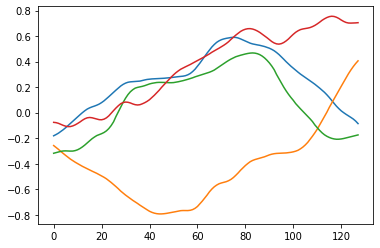

In [110]:
plt.plot(tb[0][0][batch_index, :, -4:])
0

0

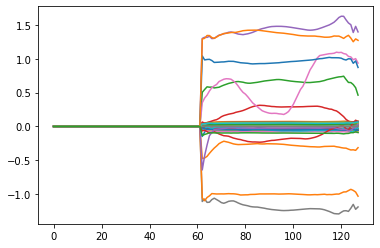

In [111]:
plt.plot(out[batch_index] * (1 - tb[0][1][batch_index, :, :33]))
0

In [112]:
vid1 = vae.decode(tb[0][0][batch_index, :, :32]) 

In [113]:
vid2 = vae.decode(out[batch_index, :, :32]) * (1 - np.reshape(tb[0][1][batch_index, :, 0], (128, 1, 1, 1)))

In [114]:
jupyter_video(np.concatenate([vid1, vid2], axis=2))


In [101]:
import videoio

In [103]:
videoio.videosave("demo1.mp4", np.concatenate([vid1, vid2], axis=2))

In [115]:
network.test_on_batch(bt)

[0.02828534, 0.02828534]